In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

exposure = 5 * 14000 / (4 * np.pi)
p = update_params(param_file, p, 'exposure', exposure)

phipp = 7.12073e-30
fwimp = phipp * 8 * np.pi / 1e-28
p = update_params(param_file, p, 'fwimp', fwimp) 

print(exposure, fwimp)

5570.423008216337 1.7896346444957159


In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

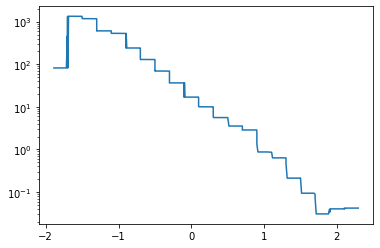

In [20]:
dat = np.loadtxt('Dataset 0-4.csv', delimiter=',')
# dat = dat[29:]
np.savetxt('residual_background.txt', dat, header='Residual bgd in counts/s as a function of log10(Energy/1 TeV)')
plt.plot(dat[:, 0], dat[:, 1])
plt.yscale('log')

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], return_all=True)
s_psh = s_psh[::2]
s_fluxes = s_fluxes[::2]

s_counts = np.arange(0, 20)

In [6]:
## SOM
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], return_all=True)

som_counts = np.arange(0, 50)

In [7]:
# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg

In [8]:
# pc for generating skymaps
s_pc_of_psi = pd.pc_of_psi(p, s_pshfunc2d, s_fluxes, s_counts)
som_pc_of_psi = pd.pc_of_psi(p, som_pshfunc2d, som_fluxes, som_counts)

# choose between s and som
pc_of_psi = s_pc_of_psi 

background = True 



largest count is 65.0 ...this may take a while


In [9]:
# search parameters
num_search = 50
p['fwimp'] *= 10
fwimp_search = (np.log10(p['fwimp'])-2, np.log10(p['fwimp'])+2, num_search)

exposure_search = np.logspace(0, 1.5, num=5) * p['exposure']

In [10]:
# run likelihoods
s_S = np.zeros((len(exposure_search), num_search))
som_S = np.zeros((len(exposure_search), num_search))
poisson_S = np.zeros((len(exposure_search), num_search))

for i, exposure in enumerate(exposure_search):
    p['exposure'] = exposure

    gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
    iso_bg = p['iso_flux_bg'] * p['exposure']
    bg_count = gal_bg + iso_bg
    
    # make the simulated skymap
    psis = np.linspace(40, 180, num=50)
    pc_psi = np.array([integrate.simps(1/fwimp * s_pshfunc2d(abs(psi), s_fluxes).flatten() * stats.poisson.pmf(s_counts[:, np.newaxis], p['exposure'] * fwimp * s_fluxes), fwimp * s_fluxes, axis=-1) for psi in psis])
    pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)
    # generate sky map
#     pc_of_psi = pd.pc_of_psi(p, s_pshfunc2d, s_fluxes, s_counts, bg_count)
    subcounts, ang_dists, bg_counts = pd.generate_skymap_sample_pc(p, pc_of_psi, return_subcounts=True, save_output=True, with_bg=background)
    print('generated skymap with', p['fwimp'])
    print(subcounts)
#     subcounts, ang_dists, bg_counts = pd.generate_skymap_sample_pc_2(p, s_pshfunc2d, s_fluxes, return_subcounts=True, save_output=True, with_bg=background)
    if np.all(subcounts == 0):
        break
    
    counts = np.arange(0, max(subcounts)+1)
    
    S, fwimps = pd.likelihood(p, s_psh, subcounts.astype(np.int16), s_fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count)
    s_S[i] = S
    print('finish swave')
    
    S, fwimps = pd.likelihood(p, som_psh, subcounts.astype(np.int16), som_fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count)
    som_S[i] = S
    print('finish som')
    
    S, fwimps = pd.poisson_likelihood(p, s_psh, subcounts.astype(np.int16), s_fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count)
    poisson_S[i] = S
    print('finish poi')
    
    print(i+1, '/', len(exposure_search))

saved in ./output/n0_skymap_43725.npy
generated skymap with 17.89634644495716
[15. 12.  7. ... 16. 10. 15.]
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0
zero prob pixels 0

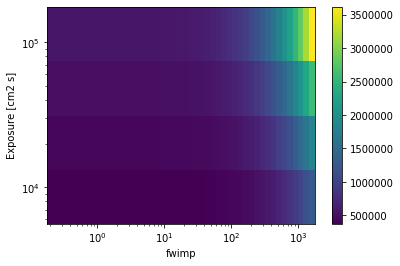

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, s_S)
fig.colorbar(pc);

In [12]:
np.amax(s_S, axis=-1), s_S[:, -1]

(array([1456644.80259254, 2076697.46695186, 2913240.56531365,
        4123852.98061136, 6082809.30125067]),
 array([1456644.80259254, 2076697.46695186, 2913240.56531365,
        4123852.98061136, 6082809.30125067]))

s-wave L 370215.05104131263 	 17.89634644495716 	 1.4148928831120564
s-wave L 431736.3782730433 	 17.89634644495716 	 1.4148928831120564
s-wave L 492759.85614379845 	 17.89634644495716 	 0.9715345639936978
s-wave L 554356.9755209307 	 17.89634644495716 	 0.8050550950319046
s-wave L 613411.5115188835 	 17.89634644495716 	 0.6671030862480289
som L -2.5543011365491993e-269 	 17.89634644495716 	 579.3866178710426
som L -2.2347004397176334e-265 	 17.89634644495716 	 273.1730476037519
som L -2.831084581897842e-263 	 17.89634644495716 	 128.79744135500755
som L -1.2452859509348311e-295 	 17.89634644495716 	 73.2840186190334
som L -1.415676e-318 	 17.89634644495716 	 41.697624801038266
poisson L 370159.8967462826 	 17.89634644495716 	 1.4148928831120564
poisson L 431696.6503647474 	 17.89634644495716 	 1.4148928831120564
poisson L 492658.03925437643 	 17.89634644495716 	 1.4148928831120564
poisson L 554212.626337852 	 17.89634644495716 	 1.1724407619543333
poisson L -2.9544010596798836e-247 	 

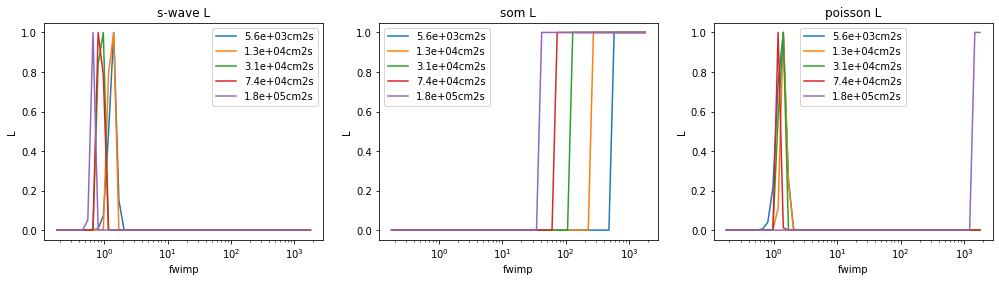

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(17, 4))
i = 0
for ax, s, lab in zip(axs, [s_S, som_S, poisson_S], ['s-wave L', 'som L', 'poisson L']):
    for expdat, expo in zip(s, exposure_search):
        print(lab, expdat.min(), '\t', p['fwimp'], '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])
        ax.plot(fwimps, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
#         ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')

    ax.set_xscale('log')
    ax.set_xlabel('fwimp')
    ax.set_ylabel('L')
    ax.set_title(lab)
    ax.legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0)
print(p['fwimp'])

In [14]:
np.mean(subcounts), np.std(subcounts), len(subcounts)

(380.31443886861314, 123.4048726129985, 70144)

In [15]:
subcounts[:100]

array([333., 244., 265., 269., 278., 248., 266., 242., 283., 260., 272.,
       247., 273., 261., 269., 260., 285., 244., 284., 246., 261., 239.,
       241., 250., 267., 266., 277., 274., 287., 287., 248., 261., 290.,
       289., 269., 256., 285., 254., 260., 260., 244., 255., 255., 278.,
       270., 257., 279., 281., 276., 256., 276., 272., 250., 273., 277.,
       291., 271., 267., 291., 248., 240., 266., 272., 248., 293., 264.,
       294., 285., 265., 251., 262., 267., 297., 276., 281., 284., 273.,
       257., 283., 291., 231., 280., 267., 275., 290., 240., 252., 265.,
       247., 258., 246., 263., 279., 276., 251., 303., 279., 274., 254.,
       280.])

In [16]:
som_S[1]

array([ 4.36274051e+005,  4.38635693e+005,  4.42098922e+005,
        4.47139118e+005,  4.54421402e+005,  4.64868155e+005,
        4.79745971e+005,  5.00775264e+005,  5.30265480e+005,
        5.71278601e+005,  6.27824327e+005,  7.05092544e+005,
        8.09731931e+005,  9.50183713e+005,  1.13707444e+006,
        1.38367307e+006,  1.70643860e+006,  2.12567849e+006,
        2.66627929e+006,  3.35848449e+006,  4.23877712e+006,
        5.35088987e+006,  6.74712398e+006,  8.49029966e+006,
        1.06557732e+007,  1.33314189e+007,  1.66019303e+007,
        2.05531781e+007,  2.53364598e+007,  3.10951596e+007,
        3.80535591e+007,  4.64966308e+007,  5.15380940e+007,
        5.32994265e+007,  5.24329743e+007,  4.74433176e+007,
        3.30284869e+007,  1.91559077e+007,  1.22911929e+007,
       -2.23470044e-265, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000,